### augument text 文本数据增强
    - 回译（效果比较好）
    - EDA（同义词替换、插入、交换和删除）（效果还行）
    - HMM-marko（质量较差）
    - syntax（依存句法、句法、语法书）（简单句还可）
    - seq2seq（深度学习同义句生成，效果不理想，seq2seq代码大都是 [https://github.com/qhduan/just_another_seq2seq] 的，效果不理想）

>- 相较于图像数据增强，文本数据增强，现在还是有很多问题的；
>- 往更严格的角度看，文本数据增强更像是同义句生成，但又不完全是，它是一个更大范围的概念；
>- 很多时候，需要文本数据增强，一个是常常遇到的数据不足，另一个就是数据不均衡。
>- 我的感觉是，文本数据增强的有效方法:
>- 一个是回译（翻译两次，例如中文到英文，然后英文再到中文），
>- 另外一个就是EDA（同义词替换、插入、交换和删除），插入和交换当时确实没有想到用

In [2]:
import tensorflow as tf
from transformers import TFXLMRobertaModel, XLMRobertaTokenizer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import transformers
from sklearn.utils import shuffle

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


### 读取、处理数据


In [3]:
train_df = pd.read_csv('../input/contradictory-my-dear-watson/train.csv')
train_df = shuffle (train_df)
train_df.head()

,id,premise,hypothesis,lang_abv,language,label
11559,ea29c228b2,"This guide will introduce you to many, but not...",The guide includes all of the popular Aegean I...,en,English,2
7229,81ac812095,oh i believe that uh mine would say the same u...,"Oh no way, I do not believe that and you can b...",en,English,2
8434,a10c05b6e5,L'officier qui avait observé la tour sud s'écr...,L'officier a été témoin de l'effondrement de l...,fr,French,0
4336,5cd7bb335d,是的，正是我的意思，你武装上阵后，就不得不汗流浃背去做，你可以去地中海俱乐部，呃，全包，包括假期,装备真的很便宜。,zh,Chinese,2
5702,57e0080d48,"Generally, FGD systems tend to be constructed ...",FGD systems tend to replicate SCR systems.,en,English,2


In [4]:
test_df = pd.read_csv('../input/contradictory-my-dear-watson/test.csv')
test_df.sample(6)

,id,premise,hypothesis,lang_abv,language
665,f437e2979e,"Mbali na LNL na Allenbrand-Drews, shitaka inat...",Allenbrand na Drews watafungwa na madai ya uongo.,sw,Swahili
1699,8ced3d2267,"She, in turn, was worshipped by her subjects a...","She was, as a result, revered by her subjects ...",en,English
4380,fba6f5ed16,The students' reaction was swift and contentio...,The students had strong reactions.,en,English
4108,06d518d463,China could never trump the warhead blizzard W...,China will likely never shoot a warhead at the...,en,English
3306,9f963b38f4,It is not possible to walk up through the wate...,The steps are covered in mossy and very slippy.,en,English
693,f266031231,The pieces paying 33.,More than 30 pieces paying.,en,English


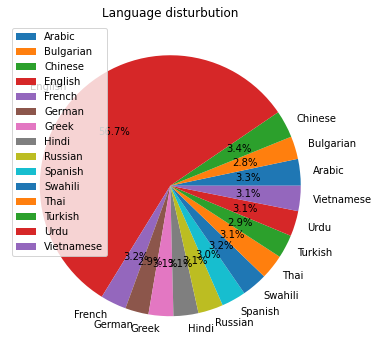

In [5]:
plt.figure(figsize = (6, 6))
#plt.bar(np.unique(train_df['language'].value_counts().index), train_df['language'].value_counts().values)<---有数值很大，效果不好
#plt.pie(train_df['language'].value_counts().values, labels=np.unique(train_df['language']))
labels, frequencies = np.unique(train_df['language'].values, return_counts = True)
#unique函数会打乱顺序，只能np.unique(return_counts = True)
plt.pie(frequencies, labels = labels, autopct = '%1.1f%%')
plt.legend(loc = 'best')
plt.title('Language disturbution')
plt.show()

> -可以看出数据不平衡，考虑text augment

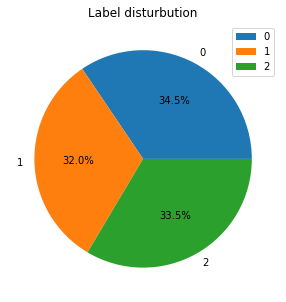

In [6]:
labels, freq = np.unique(train_df.label.values, return_counts = True)
plt.figure(figsize = (5, 5))
plt.pie(freq, labels = labels, autopct = '%1.1f%%')
plt.legend()
plt.title('Label disturbution')
plt.show()
#label = 0 -- entailment
#label = 1 -- neural
#label = 2 -- contradi

In [7]:
train_df['premise'] = train_df['premise'].apply(lambda x: x.lower())
test_df['premise'] = test_df['premise'].apply(lambda x: x.lower())
train_df['hypothesis'] = train_df['hypothesis'].apply(lambda x: x.lower())
test_df['hypothesis'] = test_df['hypothesis'].apply(lambda x: x.lower())


### 训练模型

### tensorflow 分布式计算

In [8]:
# TPU detection. No parameters necessary if TPU_NAME environment variable is
# set: this is always the case on Kaggle.
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU

print('Number of replicas:', strategy.num_replicas_in_sync) #输出设备数量

Running on TPU  grpc://10.0.0.2:8470
Number of replicas: 8


In [9]:
seed = 0
tf.random.set_seed(seed)

model_name = 'jplu/tf-xlm-roberta-large'
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)

>xlm-Roberta使用是推特语料，2.5T的推特语料对于低资源语料也覆盖的比较好，roberta对于Bert也有了一些别的改进比如去掉了nsp任务和将bert的静态mask换成动态mask，所谓动态mask就是将语料复制十份，每一份都随机选择15%的Tokens进行Masking，也就是说，同样的一句话有10种不同的mask方式。然后每份数据都训练N/10个epoch。这就相当于在这N个epoch的训练中，每个序列的被mask的tokens是会变化的。这就叫做动态Masking。

In [10]:
def build_model():
    with strategy.scope():
        
        bert_encoder = TFXLMRobertaModel.from_pretrained(model_name)
        #bert_encoder = TFRobertaModel.from_pretrained(model_name)
        
        # 定义输入（注意token为Int类型）
        input_word_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name="input_word_ids")
        input_mask = tf.keras.Input(shape=(None,), dtype=tf.int32, name="input_mask")
        
        #定义微调模型 XLMRoberta
        
        #将输入转换为Bert embedding
        embedding = bert_encoder([input_word_ids, input_mask])[0]
        
        #定义最终分类层，输出的是0、1、2三个分类，故最终dense=3
        output_layer = tf.keras.layers.Dropout(0.3)(embedding)
        output_layer = tf.keras.layers.BatchNormalization()(output_layer)
        output_layer = tf.keras.layers.GlobalAveragePooling1D()(output_layer)
        output_layer = tf.keras.layers.Dropout(0.3)(output_layer)
        output_dense_layer = tf.keras.layers.Dense(64, activation='relu')(output_layer)
        output_dense_layer = tf.keras.layers.Dense(32, activation='relu')(output_dense_layer)
        output = tf.keras.layers.Dense(3, activation='softmax')(output_dense_layer)

        # 训练参数
        model = tf.keras.Model(inputs=[input_word_ids, input_mask], outputs=output)
        model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        return model

### 尝试标准化，去掉一个Dense层，以及dropout，增大验证集，改变Batch_size等方法缓解过拟合。训练多次后发现标准化提升较大

In [11]:
# 调用并查看模型结构
with strategy.scope():
    model = build_model()
    model.summary() 


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
tfxlm_roberta_model (TFXLMRober ((None, None, 1024), 559890432   input_word_ids[0][0]             
                                                                 input_mask[0][0]                 
__________________________________________________________________________________________________
dropout_74 (Dropout)            (None, None, 1024)   0           tfxlm_roberta_model[0][0]   

In [12]:
#batch_size = 8 * strategy.num_replicas_in_sync
batch_size = 128
auto = tf.data.experimental.AUTOTUNE ##自动设置为最大的可用线程数

def make_data(train_input, train_label):
    dataset = tf.data.Dataset.from_tensor_slices(
        (
            train_input,
            train_label
        )
    ).repeat().shuffle(batch_size).batch(batch_size).prefetch(auto)
    return dataset
'''让多个特征对应一个标签。
之后把特征和标签组合成一个tuple，
那么我们的想法是让每个标签都恰好对应2个特征，而且像直接切片，比如：[f11, f12] [t1]。
f11表示第一个数据的第一个特征，f12表示第1个数据的第二个特征，t1表示第一个数据标签。
那么tf.data.Dataset.from_tensor_slices就是做了这件事情：'''

def xlm_roberta_encode(hypotheses, premises,augmentation=False):
    sentence_1 = [tokenizer.encode(s) for s in premises]
    sentence_2 = [tokenizer.encode(s) for s in hypotheses]
    input_word_ids = list(map(lambda x: x[0]+x[1], list(zip(sentence_1,sentence_2))))
    input_mask = [np.ones_like(x) for x in input_word_ids]
    inputs = {
        'input_word_ids': tf.keras.preprocessing.sequence.pad_sequences(input_word_ids, padding='post'),
        'input_mask': tf.keras.preprocessing.sequence.pad_sequences(input_mask, padding='post')
    }
    return inputs

#切分数据集 
train1_df, valid_df = train_test_split(train_df, test_size=0.2)

#数据token
train_input = xlm_roberta_encode(train1_df.premise.values, train1_df.hypothesis.values)
train_label = train1_df.label.values
valid_input = xlm_roberta_encode(valid_df.premise.values, valid_df.hypothesis.values)
valid_label = valid_df.label.values

#生成训练数据
train_seq = make_data(train_input, train_label)
tf.keras.backend.clear_session()

n_step = len(train_label)//batch_size


In [13]:
print('训练集:', len(train_label))
print('验证集:', len(valid_label))
print('测试集', len(test_df))

训练集: 9696
验证集: 2424
测试集 5195


In [14]:
with strategy.scope():
    history = model.fit(train_seq, shuffle=True, steps_per_epoch=n_step, epochs=40, verbose=1,
                       validation_data=(valid_input,valid_label),
                       callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),#10回合val没有明显提升则自动停止
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5),#观察学习率下降，factor*lr = new_lr
            tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True,save_weights_only=True)
        ]#该回调函数将在每个epoch后保存模型到filepath,save_best_only：当设置为True时，将只保存在验证集上性能最好的模型
                       )

Epoch 1/40


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


75/75 [==============================] - 103s 1s/step - accuracy: 0.3630 - loss: 1.1017 - val_accuracy: 0.4719 - val_loss: 1.0843 - lr: 1.0000e-05
Epoch 2/40
75/75 [==============================] - 52s 695ms/step - accuracy: 0.6201 - loss: 0.8447 - val_accuracy: 0.7368 - val_loss: 0.7463 - lr: 1.0000e-05
Epoch 3/40
75/75 [==============================] - 53s 702ms/step - accuracy: 0.7665 - loss: 0.5861 - val_accuracy: 0.7859 - val_loss: 0.5651 - lr: 1.0000e-05
Epoch 4/40
75/75 [==============================] - 52s 694ms/step - accuracy: 0.8193 - loss: 0.4631 - val_accuracy: 0.7946 - val_loss: 0.5284 - lr: 1.0000e-05
Epoch 5/40
75/75 [==============================] - 52s 693ms/step - accuracy: 0.8584 - loss: 0.3766 - val_accuracy: 0.8078 - val_loss: 0.5742 - lr: 1.0000e-05
Epoch 6/40
75/75 [==============================] - 42s 562ms/step - accuracy: 0.8943 - loss: 0.2908 - val_accuracy: 0.8045 - val_loss: 0.6166 - lr: 1.0000e-05
Epoch 7/40
75/75 [==============================] - 4

### 预测

In [15]:
test_input = xlm_roberta_encode(test_df.hypothesis.values, test_df.premise.values)

predition_p = model.predict(test_input)
predictions = np.argmax(predition_p, axis=-1)

In [16]:
predictions = np.argmax(predition_p, axis=-1)

submission = test_df.id.copy().to_frame()
submission['prediction'] = predictions

submission.to_csv("submission.csv", index = False)

In [17]:
submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,2
2,e98005252c,1
3,58518c10ba,1
4,c32b0d16df,0
